In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt

from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion

## Training on DECals

In [48]:
from astroNN.datasets import load_galaxy10
images_all, labels = load_galaxy10()

labels = labels.astype(np.float32)


C:\Users\Tamojeet\.astroNN\datasets\Galaxy10_DECals.h5 was found!


In [49]:
lblog = np.copy(labels)

In [55]:
labels = lblog

In [56]:
img = []
lbl = []
for k in range(2,10):
    ind = np.where(labels==k)[0][-500:]
    img.extend(images_all[ind])
    if k in [2,3,4]:
        km = 1
    elif k in [5,6,7]:
        km = 0
    elif k in [8,9]:
        km = 2
    lbl.extend([km]*len(ind))

In [58]:
#images = np.reshape(img, (3200,256,256,3))
images = np.array(img)
images.shape

(3834, 256, 256, 3)

In [59]:
import torch
import torch.nn.functional as F

image_tensor = torch.tensor(images, dtype=torch.float32)

# Compute coordinates for the top-left corner of the crop box
crop_size = 120
center_x = image_tensor.shape[2] // 2
center_y = image_tensor.shape[1] // 2
top_left_x = center_x - (crop_size // 2)
top_left_y = center_y - (crop_size // 2)

# Crop the images to 150x150 centered at the original images' centers
cropped_images = image_tensor[:, top_left_y:top_left_y+crop_size, top_left_x:top_left_x+crop_size, :]

# Use bilinear interpolation to downscale the cropped images to 69x69
downscaled_images = F.interpolate(cropped_images.permute(0, 3, 1, 2), size=(69, 69), mode='bilinear', align_corners=False)

# Convert the tensor back to a numpy array
downscaled_images_array = downscaled_images.permute(0, 2, 3, 1).numpy()  # Change back to NHWC format

# Ensure the values are within the valid range [0, 255]
downscaled_images_array = np.clip(downscaled_images_array, 0, 255).astype(np.uint8)

In [62]:
lbl = np.array(lbl)
lbl

array([1, 1, 1, ..., 2, 2, 2])

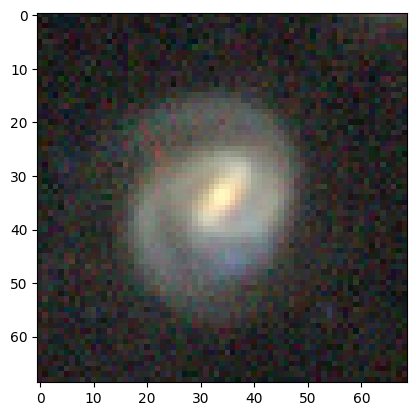

In [65]:
plt.imshow(downscaled_images_array[1500])

In [66]:
indices = np.arange(len(lbl))
np.random.shuffle(indices)
np.random.shuffle(indices)
np.random.shuffle(indices)
np.random.shuffle(indices)

images, labels = downscaled_images_array[indices], lbl[indices]

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Transpose image array to match PyTorch's tensor format (C x H x W)
        image = np.transpose(image, (2, 0, 1))

        # Convert numpy array to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Assuming you have your images and labels as numpy arrays
# images = np.load('images.npy')
# labels = np.load('labels.npy')

# Split dataset into train and validation sets
train_images, val_images = images[:3200], images[3200:]
train_labels, val_labels = labels[:3200], labels[3200:]

# Define datasets and dataloaders
train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)

# Assuming batch size is 32
batch_size = 32

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [67]:
m=256
class Net(nn.Module):
    def __init__(self, k_size=3):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=k_size)
        self.conv1 = nn.Conv2d(32, 64, kernel_size=k_size)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=k_size)
        #self.conv3 = nn.Conv2d(20, 30, kernel_size=k_size)
        self.fc1 = nn.Linear(m, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, m)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x, dim=1)
        return x

# Example usage:
net = Net(k_size=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Number of epochs
epochs = 20
curr_val_acc = prev_val_acc = 0

# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print training statistics
        running_loss += loss.item()
        if i % 40 == 39:    # Print every 100 mini-batches
            print('[%d, %5d] train loss: %.3f, train accuracy: %.2f %%' %
                  (epoch + 1, i + 1, running_loss / 100, 100 * correct / total))
            train_losses.append(running_loss / 100)
            train_accuracies.append(100 * correct / total)
            running_loss = 0.0
            correct = 0
            total = 0

    # Compute validation accuracy
    net.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        for data in val_loader:
            inputs_val, labels_val = data
            outputs_val = net(inputs_val)
            _, predicted_val = torch.max(outputs_val, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()
        val_accuracy = 100 * correct_val / total_val
        prev_val_acc, curr_val_acc = curr_val_acc, val_accuracy
        val_accuracies.append(val_accuracy)
        print('[%d] validation accuracy: %.2f %%' % (epoch + 1, val_accuracy))

    #if curr_val_acc - prev_val_acc <= 0.5:
    #    break
    net.train()

# Plot training loss, training accuracy, and validation accuracy


[1,    40] train loss: 0.480, train accuracy: 40.55 %
[1,    80] train loss: 0.352, train accuracy: 60.23 %
[1] validation accuracy: 59.31 %
[2,    40] train loss: 0.319, train accuracy: 64.69 %
[2,    80] train loss: 0.285, train accuracy: 71.09 %
[2] validation accuracy: 77.29 %
[3,    40] train loss: 0.236, train accuracy: 77.42 %
[3,    80] train loss: 0.206, train accuracy: 80.31 %
[3] validation accuracy: 80.44 %
[4,    40] train loss: 0.211, train accuracy: 78.98 %
[4,    80] train loss: 0.188, train accuracy: 81.41 %
[4] validation accuracy: 83.44 %
[5,    40] train loss: 0.164, train accuracy: 84.77 %
[5,    80] train loss: 0.167, train accuracy: 83.91 %
[5] validation accuracy: 82.33 %
[6,    40] train loss: 0.156, train accuracy: 84.69 %
[6,    80] train loss: 0.153, train accuracy: 84.30 %
[6] validation accuracy: 83.28 %
[7,    40] train loss: 0.134, train accuracy: 87.27 %
[7,    80] train loss: 0.148, train accuracy: 86.33 %
[7] validation accuracy: 85.65 %
[8,    40] tr

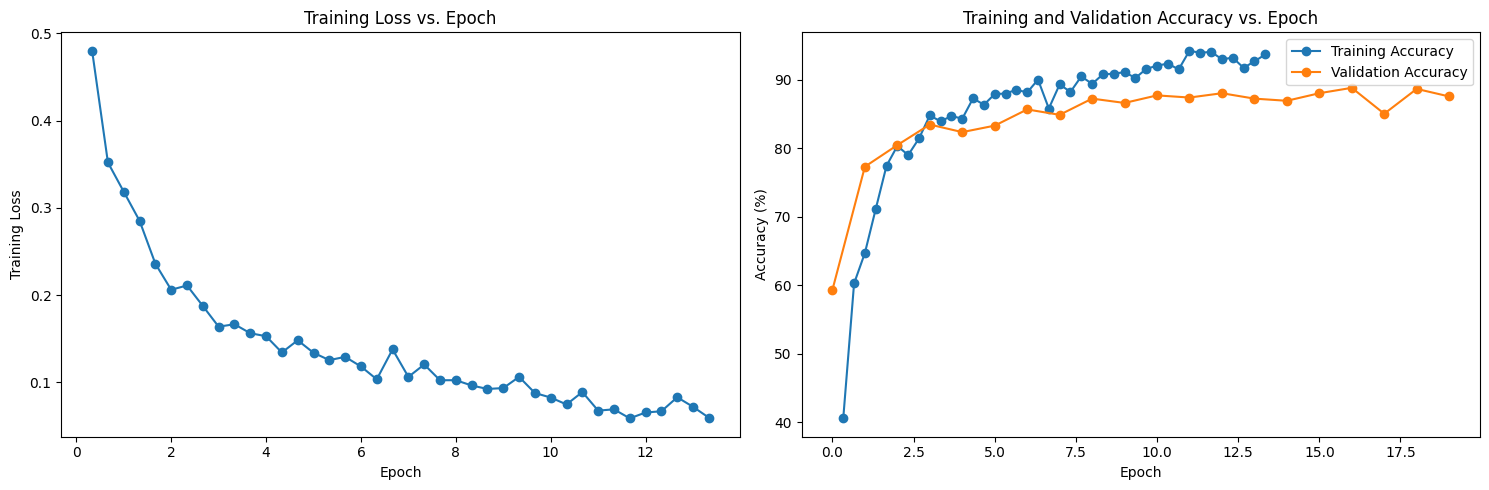

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(train_losses)+1)/3 , train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(train_losses)+1)/3, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
all_labels, all_predicted = [], []

for data in val_loader:
    inputs_val, labels_val = data
    outputs_val = net(inputs_val)
    _, predicted_val = torch.max(outputs_val, 1)
    total_val += labels_val.size(0)
    correct_val += (predicted_val == labels_val).sum().item()
    all_predicted.extend(predicted_val.tolist())
    all_labels.extend(labels_val.tolist())

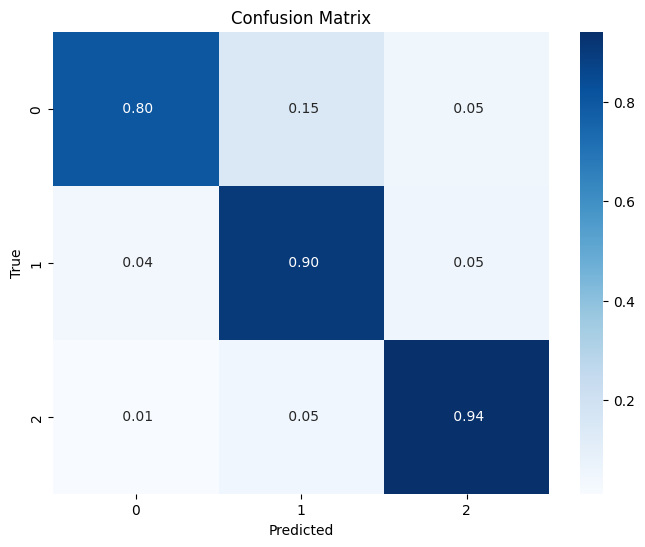

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_predicted, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=" .2f", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Testing on SDSS

C:\Users\Tamojeet\.astroNN\datasets\Galaxy10.h5 was found!


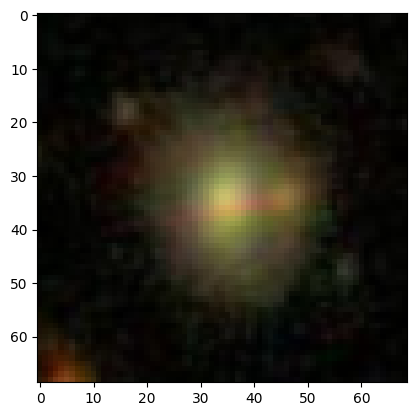

In [72]:
images, labels = load_galaxy10sdss()

labels[np.where(labels==2)] = 1
labels[np.where(labels==3)] = 1  #smooth
labels[np.where(labels==4)] = 2
labels[np.where(labels==5)] = 2
labels[np.where(labels==6)] = 2  #disk, edge-on
labels[np.where(labels==7)] = 0
labels[np.where(labels==8)] = 0
labels[np.where(labels==9)] = 0  #disk, face-on



ind = np.arange(len(labels))
np.random.shuffle(ind)
np.random.shuffle(ind)
np.random.shuffle(ind)
np.random.shuffle(ind)


images, labels = images[ind], labels[ind]
labels = np.array(labels, dtype='int')

plt.imshow(images[1010])

In [73]:
val_images = images
val_labels = labels

# Define datasets and dataloaders
#train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)

# Assuming batch size is 32
batch_size = 32

# Create dataloaders
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Overall accuracy =  3.712571726656234


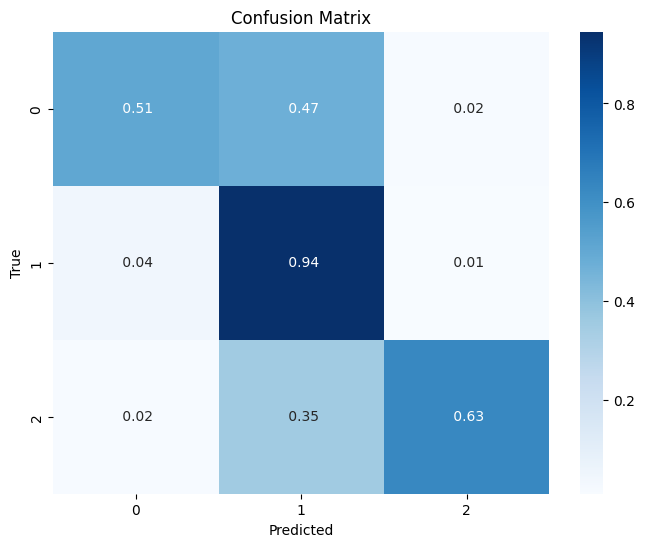

In [77]:
all_labels, all_predicted = [], []

for data in val_loader:
    inputs_val, labels_val = data
    outputs_val = net(inputs_val)
    _, predicted_val = torch.max(outputs_val, 1)
    total_val += labels_val.size(0)
    correct_val += (predicted_val == labels_val).sum().item()
    all_predicted.extend(predicted_val.tolist())
    all_labels.extend(labels_val.tolist())
    
all_labels, all_predicted = np.array(all_labels), np.array(all_predicted)

all_correct = np.where(all_labels==all_predicted)[0]
mix_correct = np.intersect1d(np.where(all_labels==all_predicted)[0], np.where(all_labels==0)[0])

print('Overall accuracy = ', (len(all_correct) - len(mix_correct))/len(np.where(cross_labels!=0)[0]))   
cm = confusion_matrix(all_labels, all_predicted, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=" .2f", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()